<a href="https://colab.research.google.com/github/emiliocicese/CDSI_2023/blob/main/Practica_HVR/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3

Emilio Hernández Arellano

In [1]:
!pip install hrv-analysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
from glob import glob
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values,get_time_domain_features, get_frequency_domain_features,get_geometrical_features
import matplotlib.pyplot as plt

In [4]:
#Importando librerías de ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
#Extracting data
def import_file(path_file):
  with open(path_file,"r") as file:
    content = file.readlines()
  data = [int(x.strip()) for x in content]
  return data

In [44]:
#Función para remover Outliers
# Y obtener características
def nn_features(list_data, l = 200, h = 1500):
  #Removiendo outliers
  rr_intervals_without_outliers = remove_outliers(rr_intervals=list_data,  
                                                low_rri=l, high_rri=h)
  interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, 
                                                   interpolation_method="linear")
  nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
  interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
  
  #Obteniendo características
  time_features = get_time_domain_features(interpolated_nn_intervals)
  freq_features = get_frequency_domain_features(interpolated_nn_intervals)

  list_feature = []
  for key in time_features:
    list_feature.append(time_features[key])

  for key in freq_features:
    list_feature.append(freq_features[key])


  return list_feature

In [10]:
#Realiza ventaneo rectangular
def split(data_list, size = 1):
  data_split = np.array_split(data_list,size)
  return data_split

In [11]:
#Obteniendo las características por archivo, si window=1 se concidera toda la señal
#en caso de ser mayor se hace un ventaneo rectangular
def obtain_features(file,label,group=None,window=1): 
  list_data_features = []
  groups,labels = [],[]
  if window > 1:
    label = (np.tile(label,window)).tolist()
    labels.extend(label)
    if group is not None:
      group = (np.ones(window)*group).tolist()
      groups.extend(group)
    data_split_list = split(data,window)
    for i in range (len(data_split_list)):
      list_data_features.append(nn_features(data_split_list[i]))
  else: 
    labels.append(label)
    groups.append(group) if group is not None else None
    list_data_features.append(nn_features(file))
  array_data = np.array(list_data_features)
  if group is not None:
    return list_data_features,labels,groups
  else:
    return list_data_features,labels

In [12]:
#Obtiene las clases del archivo, es decir verdad o mentira
def label_class(file):
  root,_ = os.path.splitext(file)
  label_object = root.split("_")[-1]
  return label_object

In [13]:
"""
Si Train es True:
  Para ello los datos deben estar en subfolders los cuales correspondan
  a los nombres de las personas, puesto que el folder principal es datos
  fisiologicos.
  Con esto se garantiza la asignación de grupos para la validación
  Leave One Group Out

  En caso de False, no importará la etiqueta de grupos; puesto que esta etiqueta
  trata de asignar a la persona a un número. Al asignar por números a los participantes
  se reduce el número de iteraciones de la validación cruzada al número de 
  participantes

  De modo que devuelve los features, clases y los grupos

Si train es False:

  Solo devuelve la clase y features

Se asume que los archivos tienen el siguiente formato:

ruta de acceso/nombreParticipante_objeto_clase.txt

Donde label_class extrae la clase del archivo, asumiendo que tiene el formato 
indicado
"""
def load_data(path,window=1,train=True):
  features=[]
  groups = []
  labels = []
  group = 1
  if train:
    #Instrucción para contar el número de folders en el directorio
    for element in os.listdir(path):
      #print(element)
      if os.path.isdir(os.path.join(path,element)):
        #Obtenemos los archivos txt
        for subelement in os.listdir (os.path.join(path,element)):
          if subelement.endswith(".txt"):
            file_object = os.path.join(path,element,subelement)
            data = import_file(file_object)
            #print(group)
            label = label_class(file_object)
            f,l,g = obtain_features(file=data,label=label,group=group,window=window)
            features.extend(f)
            groups.extend(g)
            labels.extend(l)
        group+=1
    return np.array(features),np.array(labels),groups
  else:
    for file_element in glob(path):
      data = import_file(file_element)
      label = label_class(file_element)
      f,l = obtain_features(data,label)
      features.extend(f)
      labels.extend(l)
    return features,np.array(labels)

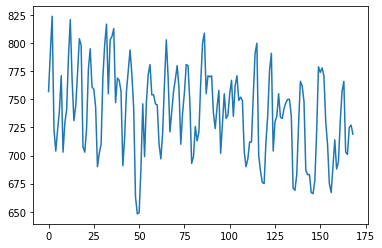

In [14]:
path_test = "/content/drive/MyDrive/CDSI/Practica_3/datos fisiologicos/Carlos H/Carlos_objeto1_verdad.txt"

data = import_file(path_test)

#Visualizando los datos
plt.plot(data)


## Extrayendo Características

### Señal completa

In [15]:
#Importando datos para la señal entera

path_train = "/content/drive/MyDrive/CDSI/Practica_3/datos fisiologicos/"
X1,y1,g1 = load_data(path=path_train,
                                   window=1,
                                   train=True)

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
6 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
1 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been delet

### Señal diviida en 3

In [30]:
#Importando datos para una señal recortada en 3 sin overlapping cada ventana

path_train = "/content/drive/MyDrive/CDSI/Practica_3/datos fisiologicos/"
X3,y3,g3 = load_data(path=path_train,
                                   window=5,
                                   train=True)

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been delet

/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 98, using nperseg = 98
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 99, using nperseg = 99
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 97, using nperseg = 97
  warnings.warn('nperseg = {0:d} is greater than input length '
/usr/local/lib/python3.8/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than i

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
0 ectopic beat(s) have been delet

##Clasificación

### SVM

#### Señal Entera

In [60]:
#Aplicando validación cruzada Leave One Group Out para
#la señal entera con el modelo svm
sv_m = svm.SVC(random_state=42)
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(X1, y1, g1):
    x_train,x_test = X1[train_index],X1[test_index]
    y_train,y_test = y1[train_index], y1[test_index]
    sv_m.fit(x_train,y_train)
    score = sv_m.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de SVM se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de SVM se tiene un accuracy de 0.36 y una std: 0.26


In [61]:
"""
Aplicando enfoque greedy para evaluar hiperparametros del svm
de la señal entera
"""

param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto']} #hiperparametros del svm

grid_search_svm = GridSearchCV(sv_m,param_grid=param_grid_svm,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_svm.fit(X=X1,y=y1,groups=g1)
best_svm = grid_search_svm.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_svm.best_params_)
print("Precisión media en validación cruzada: ", grid_search_svm.best_score_)

Mejores parámetros encontrados:  {'C': 0.1, 'gamma': 'scale'}
Precisión media en validación cruzada:  0.41111111111111115


#### Señal Partida en 3

In [62]:
#Aplicando validación cruzada Leave One Group Out para testing de una señal partida en 3
#la señal entera con el modelo svm

sv_m3 = svm.SVC()
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(X3, y3, g3):
    x_train,x_test = X3[train_index],X3[test_index]
    y_train,y_test = y3[train_index], y3[test_index]
    sv_m3.fit(x_train,y_train)
    score = sv_m3.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de SVM se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de SVM se tiene un accuracy de 0.41 y una std: 0.25


In [63]:
"""
Aplicando enfoque greedy para evaluar hiperparametros del svm
de la señal con 3 ventanas sin overshifting
"""

param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto']} #hiperparametros del svm

grid_search_svm = GridSearchCV(sv_m3,param_grid=param_grid_svm,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_svm.fit(X=X3,y=y3,groups=g3)
best_svm = grid_search_svm.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_svm.best_params_)
print("Precisión media en validación cruzada: ", grid_search_svm.best_score_)

Mejores parámetros encontrados:  {'C': 0.1, 'gamma': 'scale'}
Precisión media en validación cruzada:  0.41111111111111115


### Random Forest

#### Señal Entera

In [64]:
#Aplicando validación cruzada Leave One Group Out para
#la señal entera con el modelo Random Forest 

r_f = RandomForestClassifier()
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(X1, y1, g1):
    x_train,x_test = X1[train_index],X1[test_index]
    y_train,y_test = y1[train_index], y1[test_index]
    r_f.fit(x_train,y_train)
    score = r_f.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de Random Forest se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de Random Forest se tiene un accuracy de 0.52 y una std: 0.38


In [65]:
"""
Aplincando enfoque greedy para la señal entera con Random Forest
"""

param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20]} #hiperparametros del Random Forest

grid_search_rf = GridSearchCV(r_f,param_grid=param_grid_rf,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_rf.fit(X=X1,y=y1,groups=g1)
best_forest = grid_search_rf.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_rf.best_params_)
print("Precisión media en validación cruzada: ", grid_search_rf.best_score_)

Mejores parámetros encontrados:  {'max_depth': 20, 'n_estimators': 300}
Precisión media en validación cruzada:  0.5611111111111111


#### Señal Partida en 3

In [66]:
#Aplicando validación cruzada Leave One Group Out para testing de una señal partida en 3
#la señal entera con el modelo Random Forest

r_f3 = RandomForestClassifier()
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(X3, y3, g3):
    x_train,x_test = X3[train_index],X3[test_index]
    y_train,y_test = y3[train_index], y3[test_index]
    r_f3.fit(x_train,y_train)
    score = r_f3.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de Random Forest se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de Random Forest se tiene un accuracy de 0.42 y una std: 0.23


In [67]:
"""
Aplincando enfoque greedy para la señal ventaneada (3 ventanas sin overshifting)
 con Random Forest
"""

param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_depth': [None, 10, 20]} #hiperparametros del Random Forest

grid_search_rf = GridSearchCV(r_f3,param_grid=param_grid_rf,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_rf.fit(X=X1,y=y1,groups=g1)
best_forest = grid_search_rf.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_rf.best_params_)
print("Precisión media en validación cruzada: ", grid_search_rf.best_score_)

Mejores parámetros encontrados:  {'max_depth': 20, 'n_estimators': 100}
Precisión media en validación cruzada:  0.5944444444444444


## Extrayendo el CSV

In [55]:
import csv

In [56]:
path_cs = "/content/drive/MyDrive/CDSI/Practica_3/datos fisiologicos/*/*.csv"

def load_csv(file):
  features,labels = [],[]
  for file_cs in glob (file):
    feature = []
    basename = os.path.basename(file_cs)
    label = basename.split("_")[2]
    with open(file_cs, 'r') as file_csv:
        reader = csv.reader(file_csv)
        # Saltar las primeras 58 filas
        for i in range(58):
            next(reader)
        # Leer las filas 59 a 67 de la segunda columna
        for i in range(8):
            feature.append(next(reader)[1])

        for i in range (13):
          next(reader)

        for i in range (6):
          r = next(reader)
          feature.append(r[1])
        
        for i in range (5):
          next(reader)
        
        for i in range(4):
          feature.append(next(reader)[1])

    feature = [float(float(x)) for x in feature]
    features.append(feature)
    labels.append(label)
  return np.array(features),np.array(labels)

Xc,yc = load_csv(path_cs)
yc.shape

(37,)

Cabe recalcar que la variable de Grupos se extrae de la función load_data cuando se importan los txt, y se extrae la señal completa de los txt. Esta variable se regresa como g1 de modo que se puede reciclar

### Clasificador

#### SVM

In [68]:
#Aplicando validación cruzada Leave One Group Out para
#la señal entera con el modelo svm
sv_m_csv = svm.SVC()
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(Xc, yc, g1):
    x_train,x_test = Xc[train_index],Xc[test_index]
    y_train,y_test = yc[train_index], yc[test_index]
    sv_m_csv.fit(x_train,y_train)
    score = sv_m_csv.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de SVM se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de SVM se tiene un accuracy de 0.47 y una std: 0.30


In [58]:
"""
Aplicando enfoque greedy para evaluar hiperparametros del svm
del csv
"""

param_grid_svm = {'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto']} #hiperparametros del svm

grid_search_svm = GridSearchCV(sv_m_csv,param_grid=param_grid_svm,cv=logo,n_jobs=-1)

#Ajustando el modelo a los datos de entrenamiento
grid_search_svm.fit(X=X1,y=y1,groups=g1)
best_svm = grid_search_svm.best_estimator_
print("Mejores parámetros encontrados: ", grid_search_svm.best_params_)
print("Precisión media en validación cruzada: ", grid_search_svm.best_score_)

Mejores parámetros encontrados:  {'C': 0.1, 'gamma': 'scale'}
Precisión media en validación cruzada:  0.41111111111111115


#### Random Forest


In [59]:
#Aplicando validación cruzada Leave One Group Out para
#la señal entera con el modelo Random Forest
rf_csv = RandomForestClassifier()
logo = LeaveOneGroupOut()
scores = []

for train_index, test_index in logo.split(Xc, yc, g1):
    x_train,x_test = Xc[train_index],Xc[test_index]
    y_train,y_test = yc[train_index], yc[test_index]
    rf_csv.fit(x_train,y_train)
    score = rf_csv.score(x_test,y_test)
    scores.append(score)

# Imprimir resultados
print("Con el modelo de SVM se tiene un accuracy de %0.2f y una std: %0.2f" 
% (np.mean(scores), np.std(scores) * 2))

Con el modelo de SVM se tiene un accuracy de 0.62 y una std: 0.42
